![](https://www.nuplan.org/static/media/nuPlan_final.3fde7586.png)

### Contents

1. [Introduction](#introduction)
2. [Creating the planner](#planning)
3. [Simulating the planner](#simulation)
4. [Visualizing metrics and scenarios](#dashboard)

# Creating a new planner in nuPlan <a name="introduction"></a>


Welcome to the nuplan planning tutorial. One of the core interactions with nuplan will be to build and train your own planners and run them through nuplan's simulation pipeline for evaluation. While we discuss how to train your machine learned planners in other tutorials, in this tutorial we will show you the basic elements you will need for constructing a planner that plugs into the nuplan interface. We will also show you the basics of running the planner in simulation and visualizing the behavior and metrics for evaluation.

## Setup

To be able to access all resources within this notebook, make sure Jupyter is launched at the root of this repo. The path of the notebook should be `/notebook/<repo_root>`.

In [1]:
# (Optional) Increase notebook width for all embedded cells to display properly
from IPython.core.display import display, HTML

display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_59371/911397167.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

# Creating the planner <a name="planning"></a>

The planner is the main component responsible for determining the ego vehicle's behavior. At it's core, a planner will consume state information in the form of observations regarding its own pose, poses of other agents, and various static and dynamic map information, along with a goal, and produce a trajectory dictating the future path that the ego vehicle will attempt to follow according to a given control strategy.

<img src="media/planner_inputs_outputs_diagram.drawio.svg"/>

In nuplan, all planners will inherit from the *AbstractPlanner* class and, along with whatever additional functionality you provide it, will have to implement a few core methods. Let's take a look at the *AbstractPlanner* class.

Let's take a look at these core methods one by one.

**initialize**: This method initializes the planner with important static information including the high level goal, represented as a (x, y, heading) pose, which in practice might be provided a higher level routing system, as well as the interface for interacting with relevant map information.

**name**: The name of the planner. This one's easy!

**observation_type**: This dictates what type of observations the planner will consume to inform it's decision making. Options here include *Sensors* (raw sensor information such as images or pointclouds) and *DetectionsTracks* (outputs of an earlier perception system designed to consume sensor information and produce meaningful detections).

**compute_trajectory**: This is the core behavior of the planner, and the part you will most likely spend the most time on. This method will consume a history buffer containing discretized past ego trajectory information as well as observations of the type declared in *observation_type* up until the current time step. Correctly accounting for historical as well as current information will allow the planner to produce more stable and strategic behaviors and avoid overcorrecting in the presence of noisy observations. The *compute_trajectory* method will be responsible for producing the trajectory dictating the path the ego vehicle will attempt to follow in the future. The trajectory represents the series of ego states (identifying pose along with dynamic information such as velocities and accelerations) the vehicle will try to attain along a specified time horizon, most easily represented as a list of states along with a method to interpolate between them.


We will now use the *SimplePlanner* class as an example of how to implement the *AbstractPlanner* interface with a real planner.

In [3]:
from typing import List, Type

import numpy as np
import numpy.typing as npt

from nuplan.common.actor_state.ego_state import DynamicCarState, EgoState
from nuplan.common.actor_state.state_representation import StateSE2, StateVector2D, TimePoint
from nuplan.common.actor_state.vehicle_parameters import get_pacifica_parameters, VehicleParameters
from nuplan.planning.simulation.observation.observation_type import DetectionsTracks, Observation
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner, PlannerInitialization, PlannerInput
from nuplan.planning.simulation.trajectory.interpolated_trajectory import  InterpolatedTrajectory
from nuplan.planning.simulation.trajectory.abstract_trajectory import AbstractTrajectory
from nuplan.planning.simulation.controller.motion_model.kinematic_bicycle import KinematicBicycleModel


# class SimplePlanner(AbstractPlanner):
#     """
#     Planner going straight
#     """

#     def __init__(self,
#                  horizon_seconds: float,
#                  sampling_time: float,
#                  acceleration: npt.NDArray[np.float32],
#                  max_velocity: float = 5.0,
#                  steering_angle: float = 0.0):
#         self.horizon_seconds = TimePoint(int(horizon_seconds * 1e6))
#         self.sampling_time = TimePoint(int(sampling_time * 1e6))
#         self.acceleration = StateVector2D(acceleration[0], acceleration[1])
#         self.max_velocity = max_velocity
#         self.steering_angle = steering_angle
#         self.vehicle = get_pacifica_parameters()
#         self.motion_model = KinematicBicycleModel(self.vehicle)

#     def initialize(self, initialization: List[PlannerInitialization]) -> None:
#         """ Inherited, see superclass. """
#         pass

#     def name(self) -> str:
#         """ Inherited, see superclass. """
#         return self.__class__.__name__

#     def observation_type(self) -> Type[Observation]:
#         """ Inherited, see superclass. """
#         return DetectionsTracks  # type: ignore

#     def compute_planner_trajectory(self, current_input: PlannerInput) -> List[AbstractTrajectory]:
#         """
#         Implement a trajectory that goes straight.
#         Inherited, see superclass.
#         """
#         # Extract iteration and history
#         iteration = current_input.iteration
#         history = current_input.history

#         ego_state = history.ego_states[-1]
#         state = EgoState(
#             car_footprint=ego_state.car_footprint,
#             dynamic_car_state=DynamicCarState.build_from_rear_axle(
#                 ego_state.car_footprint.rear_axle_to_center_dist,
#                 ego_state.dynamic_car_state.rear_axle_velocity_2d,
#                 self.acceleration,
#             ),
#             tire_steering_angle=self.steering_angle,
#             is_in_auto_mode=True,
#             time_point=ego_state.time_point,
#         )
#         trajectory: List[EgoState] = [state]
#         for _ in np.arange(
#             iteration.time_us + self.sampling_time.time_us,
#             iteration.time_us + self.horizon_seconds.time_us,
#             self.sampling_time.time_us,
#         ):
#             if state.dynamic_car_state.speed > self.max_velocity:
#                 accel = self.max_velocity - state.dynamic_car_state.speed
#                 state = EgoState.build_from_rear_axle(
#                     rear_axle_pose=state.rear_axle,
#                     rear_axle_velocity_2d=state.dynamic_car_state.rear_axle_velocity_2d,
#                     rear_axle_acceleration_2d=StateVector2D(accel, 0),
#                     tire_steering_angle=state.tire_steering_angle,
#                     time_point=state.time_point,
#                     vehicle_parameters=state.car_footprint.vehicle_parameters,
#                     is_in_auto_mode=True,
#                     angular_vel=state.dynamic_car_state.angular_velocity,
#                     angular_accel=state.dynamic_car_state.angular_acceleration,
#                 )

#             state = self.motion_model.propagate_state(state, state.dynamic_car_state, self.sampling_time)
#             trajectory.append(state)

#         return InterpolatedTrajectory(trajectory)

The *SimplePlanner* is very simple indeed, electing to just drive straight according to a specified steering angle. It doesn't even take into account the observations it receives!

The *initialize*, *name*, and *observation_type* methods are straightforward implementations of the *AbstractPlanner* interface. The observation type here is declared as *DetectionsTracks* for use with processed detections coming from the perception system, though we note that the observations are completely ignored in the *compute_trajectory* method (we would still want to change this to *Sensors* for use with raw sensor data such as lidar pointclouds). Furthermore, we note the additional *\_\_init\_\_* method that sets intrinsic parameters of the planner, such as what steering angle it will follow and by how much it will accelerate.

The *compute_trajectory* method applies the motion model of the car to update the current velocity profile with the straight line acceleration specified at initialization, rolling this out according to the horizon also specified at initialization. A more advanced planner would take the observation history and map into account and try to reach the goal specified at initialization.

# Simulating the planner <a name="simulation"></a>

## Open-loop simulation
Open-loop simulation aims to evaluate the policy's capabilities to imitate the expert driver's behavior.<br />
This is essentially done through log replay as the policy's predictions do not affect the state of the simulation.

As the policy is not in full control of the vehicle, this type of simulation can only provide a high-level performance overview.

## Closed-loop simulation
Conversely, in closed-loop simulation the policy's actions alter the state of the simulation which tries to closely approximate the real-world system.

The simulation's feedback loop enables a more in-depth evaluation of the policy as compounding errors can cause future observations to significantly diverge from the ground truth.<br />
This is important in measuring distribution shifts introduced due to lack of variance in training examples through pure imitation learning.

Closed-loop simulation is further divided into two categories:
* ego closed-loop simulation with agents replayed from log (open-loop, non reactive)
* ego closed-loop simulation with agents controlled by a rule-based or learned policy (closed-loop, reactive)

## Simulation parameters

### Ego Controller

Change the controller the ego vehicle uses to track the trajectory supplied by the planner (in the case of closed-loop) or whether log replay is used (open-loop) with `ego_controller=X` where `X` is a config yaml defined in the table below. 

| Ego controller | Description | Config |
| --- | --- | --- |
| Log play back controller | Open-loop simulation via log replay | `log_play_back_controller` |
| Perfect tracking controller | Ego perfectly tracks given trajectory (closed-loop) | `perfect_tracking_controller` |

### Observation

Change the type of observation supplied to the planner with `observation=X` where `X` is a config yaml defined in the table below. 

| Observation | Description | Config |
| --- | --- | --- |
| Box observation | Bounding boxes | `box_observation` |
| IDM agents observation | Smart agent detections | `idm_agents_observation` | 
|Lidar pc observation | Lidar point clouds from the scenario | `lidar_pc_observation` |

## Prepare the simulation config

In [13]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(os.getenv('NUPLAN_TUTORIAL_PATH', ''), '../nuplan/planning/script')
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts
# SAVE_DIR = tempfile.mkdtemp()
SAVE_DIR = '/hdd/vladislav/nuplan-results'
# Select simulation parameters
EGO_CONTROLLER = 'perfect_tracking_controller'  # [log_play_back_controller, perfect_tracking_controller]
OBSERVATION = 'idm_agents_observation'  # [box_observation, idm_agents_observation, lidar_pc_observation]
CHALLENGE = 'closed_loop_reactive_agents'  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents]
DATASET_PARAMS = [
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter=all_scenarios',  # initially select all scenarios in the database
    'scenario_filter.scenario_types=[starting_straight_traffic_light_intersection_traversal, high_lateral_acceleration, changing_lane, high_magnitude_speed, low_magnitude_speed, starting_left_turn, starting_right_turn, stopping_with_lead, following_lane_with_lead, near_multiple_vehicles, traversing_pickup_dropoff, behind_long_vehicle, waiting_for_pedestrian_to_cross, stationary_in_traffic]',  # select scenario types
    'scenario_filter.num_scenarios_per_type=10',  # use 10 scenarios per scenario type
]

# Name of the experiment
EXPERIMENT = 'idm_planner_experiment'

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=simulation_hydra_paths.config_name, overrides=[
    f'group={SAVE_DIR}',
    f'experiment_name={EXPERIMENT}',
    f'job_name=planner_tutorial',
    'experiment=${experiment_name}/${job_name}/${experiment_time}',
    'worker=sequential',
    f'ego_controller={EGO_CONTROLLER}',
    f'observation={OBSERVATION}',
    f'hydra.searchpath=[{simulation_hydra_paths.common_dir}, {simulation_hydra_paths.experiment_dir}]',
    'output_dir=${group}/${experiment}',
    *DATASET_PARAMS,
])

In [21]:
print(SAVE_DIR)

/hdd/vladislav/nuplan-results


In [22]:
print(cfg.main_callback.metric_file_callback.metric_file_output_path)

ConfigAttributeError: Key 'main_callback' is not in struct
    full_key: main_callback
    object_type=dict

In [20]:
%load_ext tensorboard
%tensorboard --logdir {SAVE_DIR}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 59428), started 0:45:39 ago. (Use '!kill 59428' to kill it.)

## Launch simulation (within the notebook)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2023-03-26 01:05:32,406 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-03-26 01:05:32,408 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-03-26 01:05:32,409 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 1
Number of GPUs per node: 0
Number of threads across all nodes: 1
2023-03-26 01:05:32,409 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2023-03-26 01:05:32,409 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:29}  Building experiment folders...
2023-03-26 01:05:32,409 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  

	Folder where all results are stored: /hdd/vladislav/nuplan-results/idm_planner_experi

Converting detections to smart agents:   0%|                                      | 0/24 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:   4%|█▎                            | 1/24 [00:01<00:29,  1.29s/it]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:   0%|                                       | 0/1 [00:00<?, ?it/s]/hdd/vladi

2023-03-26 01:07:01,563 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:07:24,778 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


Converting detections to smart agents:   0%|                                       | 0/4 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]


2023-03-26 01:07:48,521 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


Converting detections to smart agents:   0%|                                      | 0/12 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]


2023-03-26 01:08:21,900 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


Converting detections to smart agents:   0%|                                      | 0/27 [00:00<?, ?it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
Converting detections to smart agents:   4%|█                             | 1/27 [00:00<00:20,  1.27it/s]/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
/hdd/vladislav/nuplan-devkit/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]


2023-03-26 01:09:31,547 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:10:06,994 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:11:12,471 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:12:41,267 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:13:22,044 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:16:45,104 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:17:12,872 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:17:21,640 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:19:41,807 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:21:15,315 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:23:06,563 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:23:43,279 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:24:27,245 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:25:24,958 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:28:01,961 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:29:06,039 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:29:21,376 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:30:15,771 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:30:39,457 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:31:10,726 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:31:23,315 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:32:43,611 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:41:32,274 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:43:33,707 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:43:46,062 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:44:10,888 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:44:38,306 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:44:56,897 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:46:05,877 WARNING {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/planner/idm_planner.py:153}  IDMPlanner could not find valid path to the target roadblock. Using longest route found instead


2023-03-26 01:47:05,086 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 140
2023-03-26 01:47:05,087 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-03-26 01:47:05,087 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:144}  Finished executing runners!
2023-03-26 01:47:05,136 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/utils.py:71}  Saved runner reports to /hdd/vladislav/nuplan-results/idm_planner_experiment/planner_tutorial/2023.03.26.01.05.27/runner_report.parquet
2023-03-26 01:47:05,136 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:41:32 [HH:MM:SS]
2023-03-26 01:47:05,485 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:70}  Metric files integration: 00:00:00 [HH:MM:SS]
2023-03-26 01

Rendering histograms: 100%|████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]


2023-03-26 01:47:07,411 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:339}  Metric summary: 00:00:01 [HH:MM:SS]
2023-03-26 01:47:07,412 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/run_simulation.py:82}  Finished running simulation!


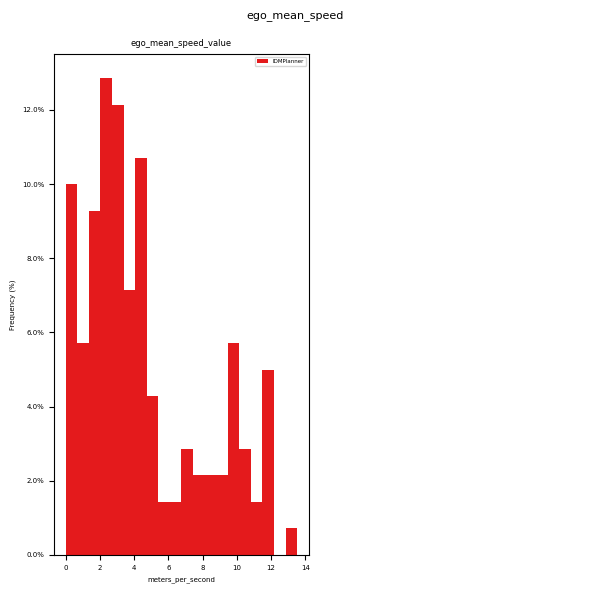

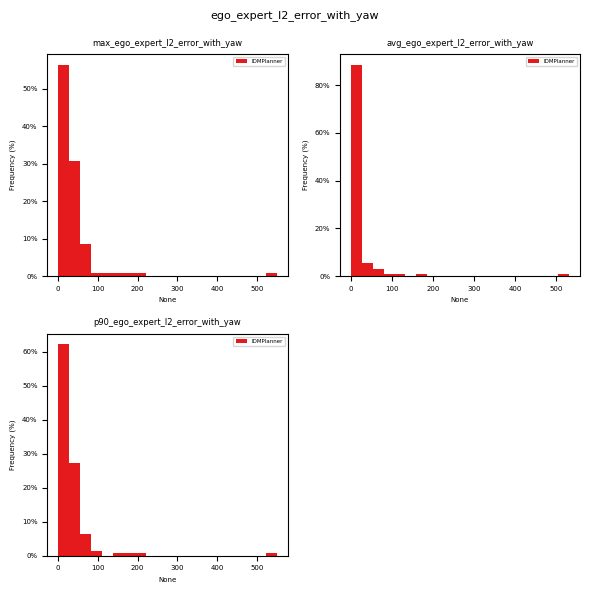

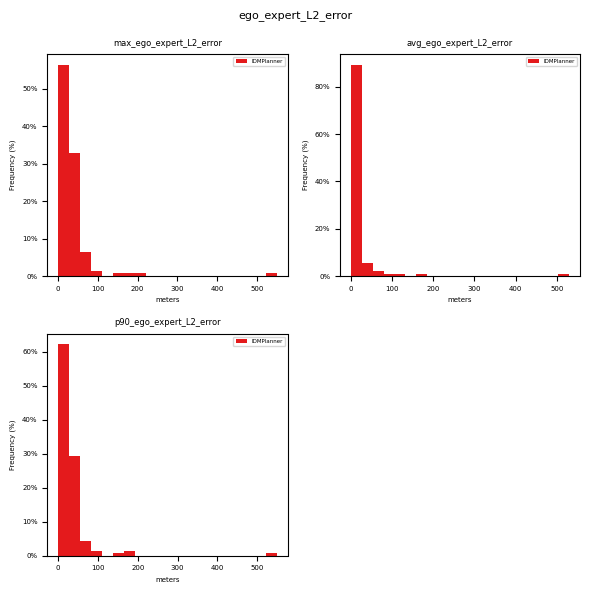

In [16]:
from nuplan.planning.script.run_simulation import run_simulation as main_simulation
from nuplan.planning.simulation.planner.idm_planner import IDMPlanner

planner = IDMPlanner(target_velocity = 10,\
                    min_gap_to_lead_agent = 1.0,\
                    headway_time = 1.5,\
                    accel_max = 1,\
                    decel_max = 3.0,\
                    planned_trajectory_samples = 16,\
                    planned_trajectory_sample_interval = 0.5,\
                    occupancy_map_radius = 40)


            
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg, planner)

# Fetch the filesystem location of the simulation results file for visualization in nuBoard (next section)
results_dir = list(list(list(Path(SAVE_DIR).iterdir())[0].iterdir())[0].iterdir())[0]  # get the child dir 2 levels in
simulation_file = [str(file) for file in results_dir.iterdir() if file.is_file() and file.suffix == '.nuboard']

# Visualizing metrics and scenarios  <a name="dashboard"></a>

In [23]:
results_dir = list(list(list(Path(SAVE_DIR).iterdir())[0].iterdir())[0].iterdir())[0]  # get the child dir 2 levels in
simulation_file = [str(file) for file in results_dir.iterdir() if file.is_file() and file.suffix == '.nuboard']

## nuBoard summary

For visualization, we use nuBoard to evaluate the planner:
* quantitatively, through common and scenario dependent metrics
* qualitatively, through visualization of scenario progression

### nuBoard tabs
To achieve that, nuBoard has 3 core evaluation tabs:
1. Overview - Scalar metrics summary of common and scenario metrics across the following categories:
    * Ego dynamics
    * Traffic violations
    * Expert imitation
    * Planning & navigation
    * Scenario performance
2. Histograms - Histograms over metric statistics for more a granular peek inside each metric focusing on:
    * Metric statistics (e.g. min, max, p90)
3. Scenarios - Low-level scenario visualizations:
    * Time-series progression of a specific metric across a scenario
    * Top-down visualization of the scenario across time for comparing predicted vs. expert trajectories

In addition, there is a main configuration tab for selecting different simulation files for comparing planners/experiments.

<br />

**NOTE**: nuBoard is under heavy developement, overall functionality and aesthetics do not represent the final product!

## Prepare the nuBoard config

In [24]:
from tutorials.utils.tutorial_utils import construct_nuboard_hydra_paths

# Location of paths with all nuBoard configs
nuboard_hydra_paths = construct_nuboard_hydra_paths(BASE_CONFIG_PATH)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=nuboard_hydra_paths.config_path)

# Compose the configuration
cfg = hydra.compose(config_name=nuboard_hydra_paths.config_name, overrides=[
    'scenario_builder=nuplan_mini',  # set the database (same as simulation) used to fetch data for visualization
    f'simulation_path={simulation_file}',  # nuboard file path, if left empty the user can open the file inside nuBoard
    f'hydra.searchpath=[{nuboard_hydra_paths.common_dir}, {nuboard_hydra_paths.experiment_dir}]',
])

INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


## Launch nuBoard (open in new tab)

In [25]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

INFO:bokeh.server.server:Starting Bokeh server version 2.4.3 (running on Tornado 6.2)


2023-03-26 01:50:10,766 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-03-26 01:50:10,787 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-03-26 01:50:10,789 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:70}  Opening Bokeh application on http://localhost:5006/


OSError: [Errno 98] Address already in use

2023-03-26 01:50:18,248 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0014 seconds.
2023-03-26 01:50:18,356 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (::1) 179.06ms


INFO:tornado.access:200 GET / (::1) 179.06ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:tornado.access:101 GET /ws (::1) 0.43ms
INFO:bokeh.server.views.ws:ServerConnection created


2023-03-26 01:50:18,634 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (::1) 0.43ms
2023-03-26 01:55:33,935 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0195 seconds.
2023-03-26 01:55:33,999 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0171 seconds.
2023-03-26 01:56:30,209 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0158 seconds.
2023-03-26 01:56:30,908 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0160 seconds.
2023-03-26 01:56:43,014 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0180 seconds.
2023-03-26 01:56:44,646 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs

INFO:tornado.access:200 GET / (::1) 184.21ms
INFO:bokeh.server.views.ws:WebSocket connection closed: code=1001, reason=None


2023-03-26 01:57:53,076 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0014 seconds.
2023-03-26 01:57:53,183 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (::1) 184.21ms


INFO:tornado.access:101 GET /ws (::1) 0.44ms
INFO:bokeh.server.views.ws:WebSocket connection opened
INFO:bokeh.server.views.ws:ServerConnection created


2023-03-26 01:57:53,449 INFO {/home/vladislav/anaconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (::1) 0.44ms
2023-03-26 01:58:03,193 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0177 seconds.
2023-03-26 01:58:03,246 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0174 seconds.
2023-03-26 01:58:12,428 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0177 seconds.
2023-03-26 01:58:12,481 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0177 seconds.
2023-03-26 02:37:18,843 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:479}  Rending scenario plot takes 0.0159 seconds.
2023-03-26 02:37:19,308 INFO {/hdd/vladislav/nuplan-devkit/nuplan/planning/nuboard/tabs